# Importing Libraries

In [1]:
import os
import torch
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import glob
from torchvision.transforms import v2
from tqdm import tqdm

In [2]:
# set the seed for generating random numbers
torch.manual_seed(42)

In [3]:
# set gpu, mps or cpu device for training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
# define mask path
mask_paths = glob.glob('/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
image_paths = [i.replace('_mask', '') for i in mask_paths]
print(f'{len(mask_paths)} {len(image_paths)}')

3929 3929


# Helper Functions

In [5]:
def plot_from_img_path(n_examples, list_img_paths, list_mask_paths):
    fig, axs = plt.subplots(n_examples, 3, figsize=(20, n_examples*7), constrained_layout=True)
    i = 0
    for ax in axs:
        image, mask = list_img_paths[i], list_mask_paths[i]
        image, mask = cv2.imread(image), cv2.imread(mask)
        ax[0].set_title("MRI images")
        ax[0].imshow(image)
        ax[1].set_title("Highlited abnormality")
        ax[1].imshow(image)
        ax[1].imshow(mask, alpha=0.2)
        ax[2].imshow(mask)
        ax[2].set_title("Abnormality mask")
        i +=1

# Visualizing Images and Masks

In [6]:
plot_from_img_path(n_examples=5, list_img_paths=image_paths[5:], list_mask_paths=mask_paths[5:])

# Creating Dataframe and Splitting Dataset into Train, Validation and Test Sets

In [7]:
df = pd.DataFrame(data={'image': image_paths, 'mask': mask_paths})
df.head()
plot_from_img_path(n_examples=3, list_img_paths=df.iloc[[3, 4, 5], 0].tolist(), list_mask_paths=df.iloc[[3, 4, 5], 1].tolist())

In [8]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
df_test, df_val = train_test_split(df_test, test_size=0.3, random_state=42)
print('train')
print(f"{df_train.describe().loc['count', ['image', 'mask']]}\n")
print('val')
print(f"{df_val.describe().loc['count', ['image', 'mask']]}\n")
print('test')
print(f"{df_test.describe().loc['count', ['image', 'mask']]}\n")

train
image    2750
mask     2750
Name: count, dtype: object

val
image    354
mask     354
Name: count, dtype: object

test
image    825
mask     825
Name: count, dtype: object



In [9]:
class MRI_Dataset(Dataset):
    def __init__(self, df, img_transform=None, mask_transform=None):
        self.image_paths = df['image']
        self.mask_paths = df['mask']
        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_file = self.image_paths.iloc[idx]
        mask_file = self.mask_paths.iloc[idx]

        img = cv2.imread(img_file, cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

        if self.img_transform:
            img = self.img_transform(img)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return img, mask
        

In [10]:
train_img_transform = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
])
train_mask_transform = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [11]:
val_img_transform = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
])
val_mask_transform = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
])

In [12]:
test_img_transform = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
])
test_mask_transform = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
])

In [13]:
train_dataset = MRI_Dataset(df_train, img_transform=train_img_transform, mask_transform=train_mask_transform)
val_dataset = MRI_Dataset(df_val, img_transform=val_img_transform, mask_transform=val_mask_transform)
test_dataset = MRI_Dataset(df_test, img_transform=test_img_transform, mask_transform=test_mask_transform)

In [14]:
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [15]:
for img, mask in train_dataloader:
    print(img.shape)
    print(mask.shape)
    break

torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 256, 256])


# Building the U-Net model
Both the image and mask have the same image size (256 x 256)

In [16]:
class conv_relu(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.relu(self.batchnorm2(self.conv2(x)))

        return x

# Increase resolution of image using nearest neighbour
class upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upconv = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=2, padding='same')
        )

    def forward(self, x):
        x = self.upconv(x)

        return x

def copy_crop(contract, expand):
    start_h = (contract.shape[2] - expand.shape[2]) // 2
    start_w = (contract.shape[3] - expand.shape[3]) // 2
    end_h = start_h + expand.shape[2]
    end_w = start_w + expand.shape[3]
    cropped_contract = contract[:, :, start_h:end_h, start_w:end_w]

    concatenated = torch.cat((cropped_contract, expand), dim=1)

    return concatenated

In [17]:
class U_Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = conv_relu(3, 64)
        self.conv2 = conv_relu(64, 128)
        self.conv3 = conv_relu(128, 256)
        self.conv4 = conv_relu(256, 512)
        self.conv5 = conv_relu(512, 1024)

        self.upsample1 = upsample(1024, 512)
        self.conv6 = conv_relu(1024, 512)

        self.upsample2 = upsample(512, 256)
        self.conv7 = conv_relu(512, 256)

        self.upsample3 = upsample(256, 128)
        self.conv8 = conv_relu(256, 128)

        self.upsample4 = upsample(128, 64)
        self.conv9 = conv_relu(128, 64)

        self.conv1x1 = nn.Conv2d(64, num_classes, kernel_size=1, stride=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.conv1(x)
        x = self.downsample(x1)
        x2 = self.conv2(x)
        x = self.downsample(x2)
        x3 = self.conv3(x)
        x = self.downsample(x3)
        x4 = self.conv4(x)
        x = self.downsample(x4)
        x = self.conv5(x)

        x = self.upsample1(x)
        x = copy_crop(x4, x)
        x = self.conv6(x)

        x = self.upsample2(x)
        x = copy_crop(x3, x)
        x = self.conv7(x)

        x = self.upsample3(x)
        x = copy_crop(x2, x)
        x = self.conv8(x)
        
        x = self.upsample4(x)
        x = copy_crop(x1, x)
        x = self.conv9(x)
        x = self.conv1x1(x)
        x = self.sigmoid(x)
        
        return x

In [18]:
model = U_Net(num_classes=1).to(device)
print(model)

U_Net(
  (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): conv_relu(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2): conv_relu(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv3): conv_relu(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (co

In [19]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=0.99)

# Training loop

In [20]:
def training_loop(epochs, model, train_dataloader, val_dataloader, 
                  loss_fn, optimizer):
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(1, epochs+1):
        model.train()
        running_train_loss = 0
        for data in tqdm(train_dataloader):
            img, mask = data
            img, mask = img.to(device), mask.to(device)
            pred = model(img)
            loss = loss_fn(pred, mask)
            running_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            running_val_loss = 0
            for data in tqdm(val_dataloader):
                img, mask = data
                img, mask = img.to(device), mask.to(device)
                pred = model(img)
                loss = loss_fn(pred, mask)
                running_val_loss += loss.item()

        train_loss = running_train_loss / len(train_dataloader.dataset)
        val_loss = running_val_loss / len(val_dataloader.dataset)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss} | Validation loss: {val_loss}')
        
    model.eval()
    return history

In [21]:
epochs = 20
history = training_loop(epochs, model, train_dataloader, val_dataloader, loss_fn, optimizer)

  0%|          | 0/172 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv2d(
100%|██████████| 23/23 [00:12<00:00,  1.85it/s]


Epoch: 1/20 | Training loss: 0.0069259847036816855 | Validation loss: 0.0020212865602961703


100%|██████████| 23/23 [00:05<00:00,  4.49it/s]


Epoch: 2/20 | Training loss: 0.0016370952816849404 | Validation loss: 0.0017447344837762879


100%|██████████| 23/23 [00:07<00:00,  2.89it/s]


Epoch: 3/20 | Training loss: 0.001419525376775048 | Validation loss: 0.001513907946330511


100%|██████████| 23/23 [00:05<00:00,  4.13it/s]


Epoch: 4/20 | Training loss: 0.0012454363234679806 | Validation loss: 0.0012331064593173184


100%|██████████| 23/23 [00:05<00:00,  4.59it/s]


Epoch: 5/20 | Training loss: 0.001102728386324915 | Validation loss: 0.001214254476158948


100%|██████████| 23/23 [00:04<00:00,  4.64it/s]


Epoch: 6/20 | Training loss: 0.0009969203006476165 | Validation loss: 0.0010994842527881476


100%|██████████| 23/23 [00:04<00:00,  4.68it/s]


Epoch: 7/20 | Training loss: 0.0009117560721087185 | Validation loss: 0.0010706827633839566


100%|██████████| 23/23 [00:05<00:00,  4.54it/s]


Epoch: 8/20 | Training loss: 0.000848072117279199 | Validation loss: 0.0009972304704278117


100%|██████████| 23/23 [00:05<00:00,  4.57it/s]


Epoch: 9/20 | Training loss: 0.0008043850502845916 | Validation loss: 0.0009921599096839914


100%|██████████| 23/23 [00:05<00:00,  4.56it/s]


Epoch: 10/20 | Training loss: 0.0007590271491049365 | Validation loss: 0.0009111002659639554


100%|██████████| 23/23 [00:04<00:00,  4.62it/s]


Epoch: 11/20 | Training loss: 0.0007297599795697765 | Validation loss: 0.0009085830290522952


100%|██████████| 23/23 [00:04<00:00,  4.61it/s]


Epoch: 12/20 | Training loss: 0.00069004801643843 | Validation loss: 0.0009297249144164183


100%|██████████| 23/23 [00:05<00:00,  4.41it/s]


Epoch: 13/20 | Training loss: 0.0006654926540160722 | Validation loss: 0.0008691745299824887


100%|██████████| 23/23 [00:05<00:00,  4.51it/s]


Epoch: 14/20 | Training loss: 0.0006509348960508677 | Validation loss: 0.0008133048373195579


100%|██████████| 23/23 [00:05<00:00,  4.25it/s]


Epoch: 15/20 | Training loss: 0.0006139744571833448 | Validation loss: 0.0007672458821328851


100%|██████████| 23/23 [00:04<00:00,  4.65it/s]


Epoch: 16/20 | Training loss: 0.0005788224115121093 | Validation loss: 0.0007367899717566081


100%|██████████| 23/23 [00:04<00:00,  4.65it/s]


Epoch: 17/20 | Training loss: 0.000549915679984472 | Validation loss: 0.0008394844661661461


100%|██████████| 23/23 [00:05<00:00,  4.59it/s]


Epoch: 18/20 | Training loss: 0.0005290868769780817 | Validation loss: 0.0007409260026826691


100%|██████████| 23/23 [00:04<00:00,  4.65it/s]


Epoch: 19/20 | Training loss: 0.0005054402547049738 | Validation loss: 0.0006803715463202076


100%|██████████| 23/23 [00:04<00:00,  4.65it/s]

Epoch: 20/20 | Training loss: 0.0004797634784216908 | Validation loss: 0.000703605198390824


# Results

In [22]:
plt.figure(figsize=(6,6))
plt.plot(np.arange(1,epochs+1), history['train_loss'], label='Training loss')
plt.plot(np.arange(1,epochs+1), history['val_loss'], label='Validation loss')
plt.xticks([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90])
plt.grid()
plt.legend()
plt.show()


In [23]:
def test_set_evaluation(models):
    for key, model in models.items():
        with torch.no_grad():
            running_loss = 0
            for i, data in enumerate(test_dataloader):
                img, mask = data
                img, mask = img.to(device), mask.to(device)
                predictions = model(img)
                loss = loss_fn(predictions, mask)
                running_loss += loss.item() * img.size(0)
            loss = running_loss / len(test_dataset)
            
            print(f'Test loss with {key}: {loss}')

In [24]:
test_set_evaluation({"current_model": model})

Test loss with current_model: 0.010407384746341092


# Saving the Binary Predicted Masks

In [25]:
import os
import random
import torch
import matplotlib.pyplot as plt
import zipfile

def visualize_segmentation(model, dataloader, num_examples=1):
    model.eval()  

    # Create directory to save results
    save_dir = "./segmentation_results"
    os.makedirs(save_dir, exist_ok=True)

    # Get all indices of the dataset and randomly sample 'num_examples' indices
    dataset_size = len(dataloader.dataset)
    random_indices = random.sample(range(dataset_size), num_examples)

    for idx in random_indices:
        img, mask = dataloader.dataset[idx]  # Access the dataset by index
        img, mask = img.to(device).unsqueeze(0), mask.to(device).unsqueeze(0)  # Add batch dimension

        with torch.no_grad():
            pred = model(img)

        # Squeeze to remove batch and channel dimensions
        img = img.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert to HWC format for display
        mask = mask.squeeze(0).squeeze(0).cpu().numpy()
        pred = pred.squeeze(0).squeeze(0).cpu().numpy()
        binary_pred = pred > 0.5

        # Plot
        fig, axes = plt.subplots(1, 4, figsize=(12, 4))
        axes[0].imshow(img, cmap='gray' if img.shape[-1] == 1 else None)
        axes[0].set_title('Input Image')
        axes[0].axis('off')

        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('True Mask')
        axes[1].axis('off')

        axes[2].imshow(pred, cmap='gray')
        axes[2].set_title('Predicted Mask')
        axes[2].axis('off')

        axes[3].imshow(binary_pred, cmap='gray')
        axes[3].set_title('Binary Predicted Mask')
        axes[3].axis('off')

        plt.tight_layout()
        plt.show()

        # Save the figure
        save_path = os.path.join(save_dir, f'segmentation_{idx}.png')
        fig.savefig(save_path)
        plt.close(fig)

    # Create a zip file of the segmentation results
    zip_path = "./segmentation_results.zip"
    with zipfile.ZipFile(zip_path, 'w') as zipf:
        for root, dirs, files in os.walk(save_dir):
            for file in files:
                zipf.write(os.path.join(root, file), arcname=file)

    print(f"Saved segmentation results in: {save_dir}")
    print(f"Created zip file at: {zip_path}")

    # Provide download link for automatic download (works in Kaggle)
    from IPython.display import FileLink
    display(FileLink(zip_path))

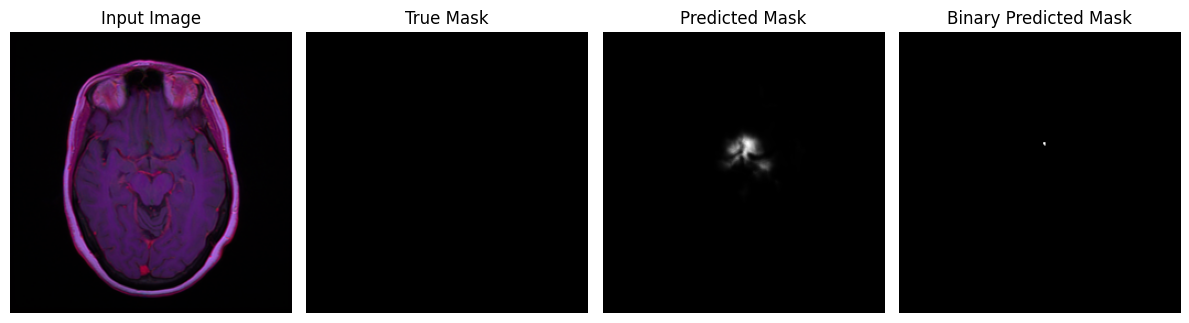

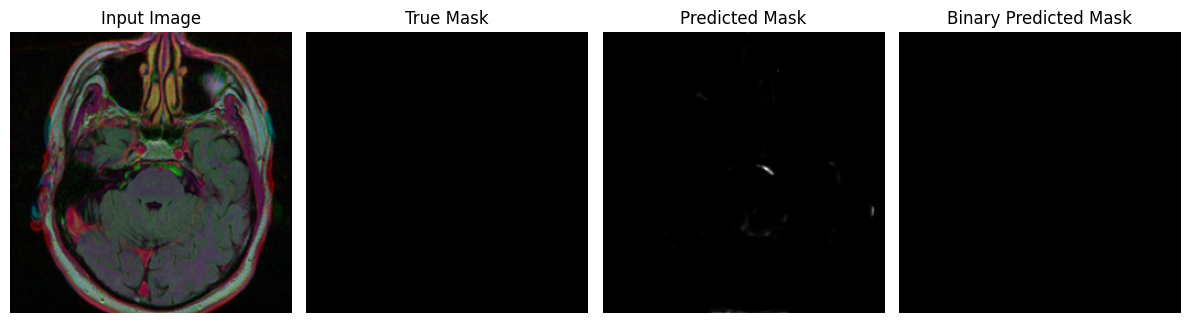

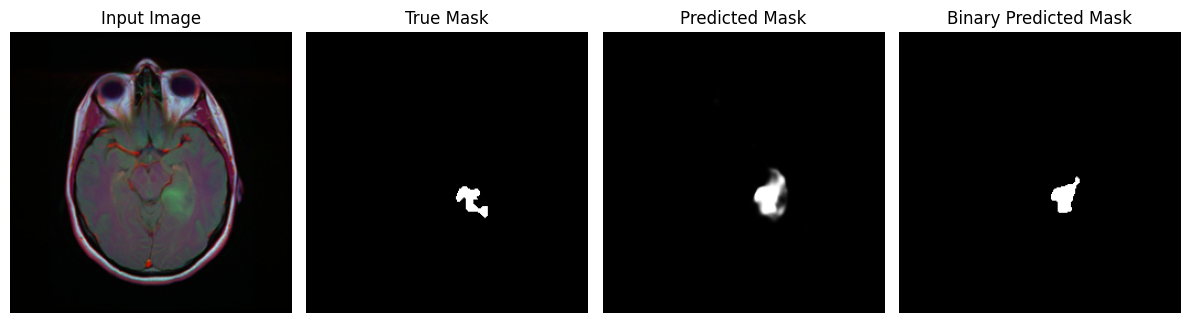

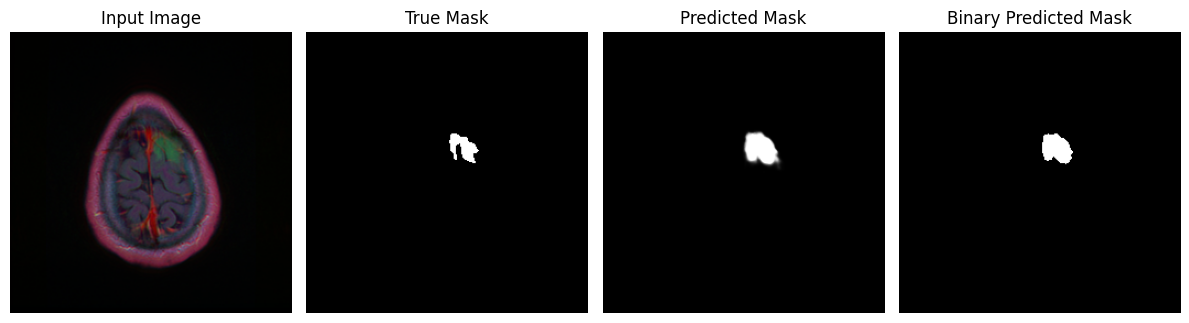

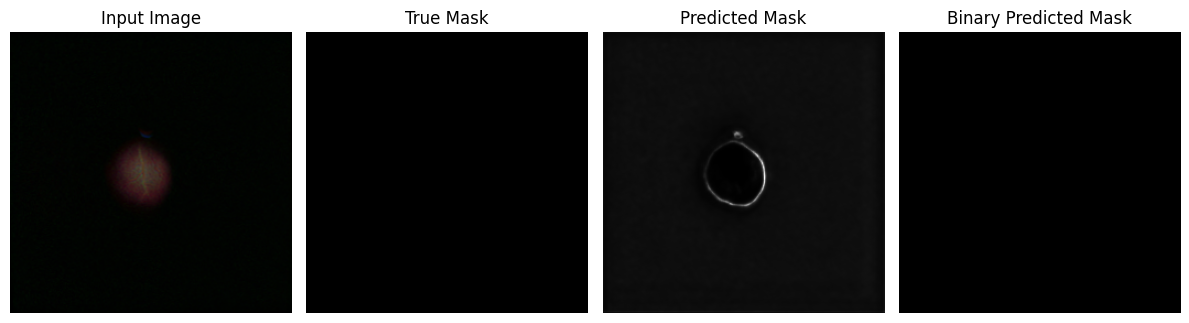

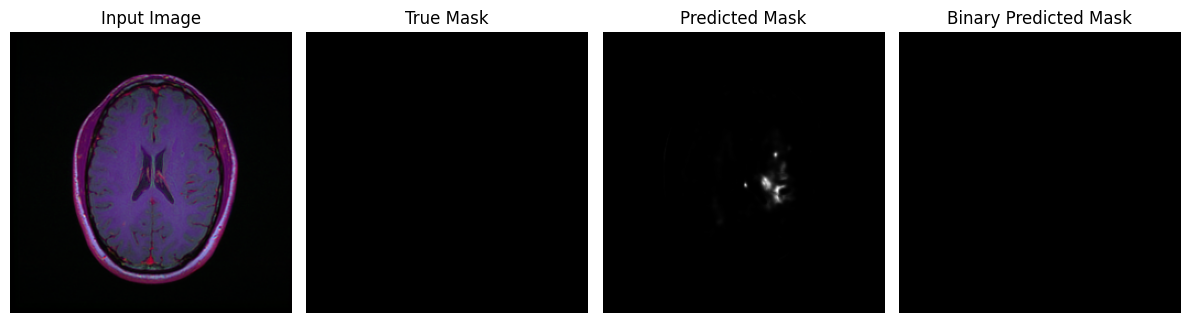

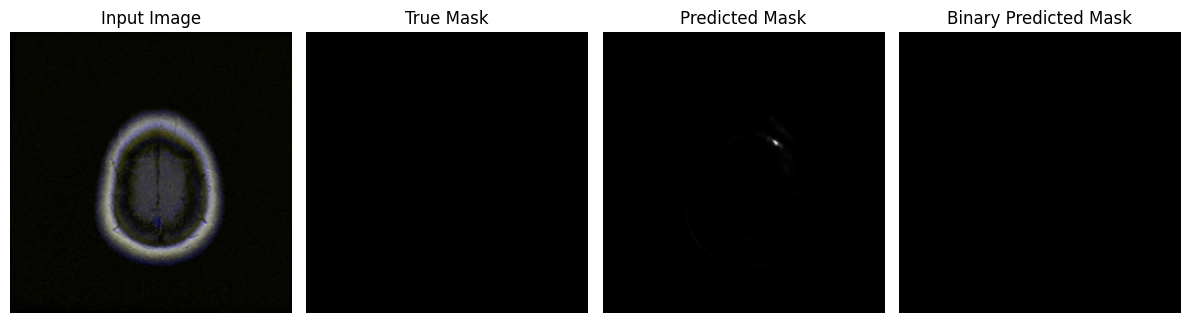

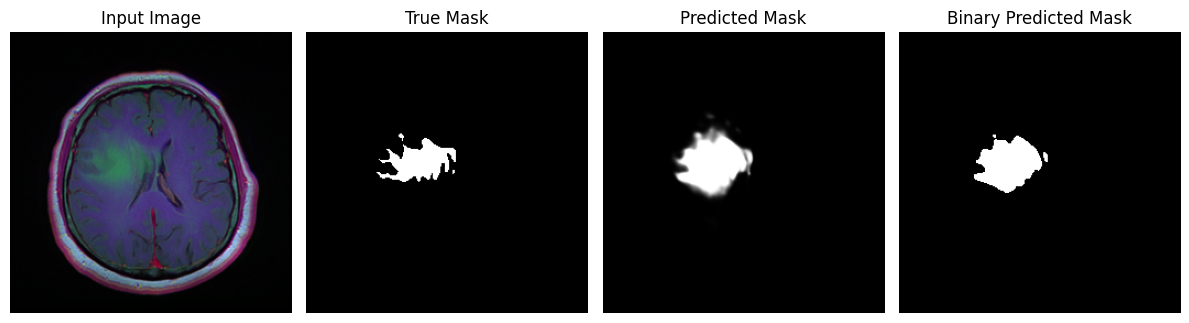

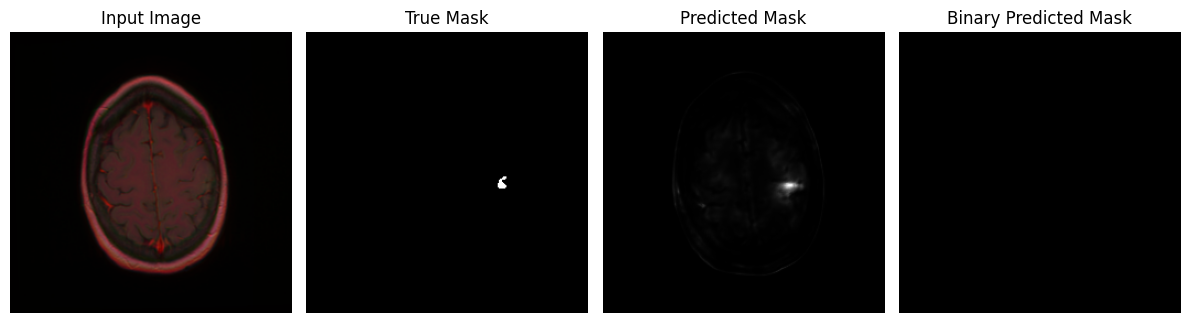

Saved segmentation results in: ./segmentation_results
Created zip file at: ./segmentation_results.zip


/kaggle/working/segmentation_results.zip

In [26]:
visualize_segmentation(model, test_dataloader, 10)

In [27]:
torch.save(model.state_dict(), "u_net_model.pth")

# Perfromance Metrics

In [28]:
def calculate_metrics(preds, masks):
    smooth = 1e-6  # To avoid division by zero

    preds = (preds > 0.5).float()  # Convert to binary mask
    intersection = (preds * masks).sum()  # Intersection pixels
    union = preds.sum() + masks.sum() - intersection  # Union pixels

    iou = (intersection + smooth) / (union + smooth)  # IoU Score
    dice = (2.0 * intersection + smooth) / (preds.sum() + masks.sum() + smooth)  # Dice Score
    accuracy = (preds == masks).float().mean()  # Pixel Accuracy

    return iou.item(), dice.item(), accuracy.item()

# Example evaluation
model.eval()
with torch.no_grad():
    for images, masks in val_dataloader:  # Replace with your validation DataLoader
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        iou, dice, acc = calculate_metrics(outputs, masks)
        print(f"IoU: {iou:.4f}, Dice: {dice:.4f}, Accuracy: {acc:.4f}")
        break  # Check one batch


IoU: 0.8510, Dice: 0.9195, Accuracy: 0.9986


In [29]:
iou_scores = []
dice_scores = []
accuracies = []

model.eval()
with torch.no_grad():
    for images, masks in tqdm(test_dataloader):  # Replace with your test DataLoader
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        iou, dice, acc = calculate_metrics(outputs, masks)
        
        iou_scores.append(iou)
        dice_scores.append(dice)
        accuracies.append(acc)

print(f"Mean IoU: {np.mean(iou_scores):.4f}")
print(f"Mean Dice Score: {np.mean(dice_scores):.4f}")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")


100%|██████████| 52/52 [00:11<00:00,  4.61it/s]

Mean IoU: 0.7881
Mean Dice Score: 0.8801
Mean Accuracy: 0.9975
